## Priprava okolja in nalaganje knjižnic

In [47]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil # Za brisanje map, če jih želimo ponastaviti
import random
import mediapipe as mp
import math

## 1 Ekstrakcija frejmov iz videa

In [48]:
# Definiramo pot do video datoteke in izhodne mape test
video_path = '../data/raw/video/selfiVideo.mp4' # Prilagodi to pot do tvojega videa
output_frames_folder = '../data/persons/oseba_1/frames/'

# Začnimo s čisto mapo, da se ne nabirajo stari frejmi
if os.path.exists(output_frames_folder):
    shutil.rmtree(output_frames_folder) # Pobrišemo mapo, če že obstaja
os.makedirs(output_frames_folder, exist_ok=True) # Sedaj ustvarimo novo, prazno mapo

# Odpremo video
vidcap = cv2.VideoCapture(video_path)
success, image = vidcap.read()
count = 0
frame_save_interval = 5 # Vsak 5. frejm

print(f"Začenjam z ekstrakcijo frejmov iz videa: {video_path}")

while success:
    # Shranimo samo vsak 'frame_save_interval' frejm, da ne preobremenimo sistema
    if count % frame_save_interval == 0:
        frame_filename = os.path.join(output_frames_folder, f"frame_{count:04d}.jpg")
        cv2.imwrite(frame_filename, image)
        # print(f"Shranjujem frejm: {frame_filename}") # Lahko vključiš, če želiš videti vsak frejm
    success, image = vidcap.read()
    count += 1

print(f"Končana ekstrakcija. Skupaj obdelano {count} frejmov. Shranjenih {len(os.listdir(output_frames_folder))} slik v {output_frames_folder}.")

Začenjam z ekstrakcijo frejmov iz videa: ../data/raw/video/selfiVideo.mp4
Končana ekstrakcija. Skupaj obdelano 377 frejmov. Shranjenih 76 slik v ../data/persons/oseba_1/frames/.


## 2 Odstranjevanje šuma iz vseh frejmov in prikaz primera

Začenjam z odstranjevanjem šuma iz 76 slik...
Končano odstranjevanje šuma. Očiščene slike shranjene v: ../data/persons/oseba_1/intermediate/


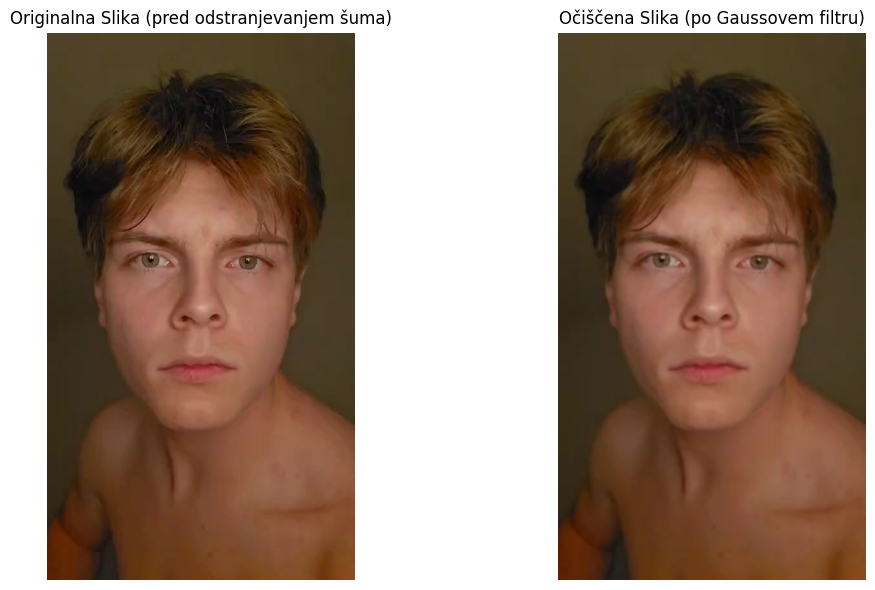

In [49]:
# Definiramo mapo z originalnimi frejmi in mapo za očiščene frejme
input_frames_folder = output_frames_folder # To so frejmi, ki smo jih ravnokar ekstrahirali
output_cleaned_folder = '../data/persons/oseba_1/intermediate/'

# Pripravimo mapo za očiščene frejme
if os.path.exists(output_cleaned_folder):
    shutil.rmtree(output_cleaned_folder)
os.makedirs(output_cleaned_folder, exist_ok=True)

all_frames = sorted(os.listdir(input_frames_folder))
example_original_image_rgb = None
example_cleaned_image_rgb = None
example_processed = False # Zastavica, da prikažemo samo en primer

print(f"Začenjam z odstranjevanjem šuma iz {len(all_frames)} slik...")

for i, frame_name in enumerate(all_frames):
    frame_path = os.path.join(input_frames_folder, frame_name)
    image_bgr = cv2.imread(frame_path)

    if image_bgr is None:
        print(f"Opozorilo: Slike ni mogoče naložiti: {frame_path}. Preskakujem.")
        continue

    # OpenCV bere BGR, MediaPipe in Matplotlib pa pričakujeta RGB
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # --- Uporabimo Gaussov filter za odstranjevanje šuma ---
    # Jedro (kernel size) 5x5 je dobra začetna točka. Boljše vrednosti lahko preizkusim kasneje.
    # Večje jedro pomeni boljše zglajevanje, a tudi večjo izgubo detajlov.
    cleaned_image_rgb = cv2.GaussianBlur(image_rgb, (5, 5), 0)

    # Shranimo očiščeno sliko v novo mapo
    cleaned_frame_filename = os.path.join(output_cleaned_folder, f"cleaned_{frame_name}")
    cv2.imwrite(cleaned_frame_filename, cv2.cvtColor(cleaned_image_rgb, cv2.COLOR_RGB2BGR))

    # Shrani en primer za prikaz
    if not example_processed:
        example_original_image_rgb = image_rgb
        example_cleaned_image_rgb = cleaned_image_rgb
        example_processed = True # Po prvem primeru nastavimo na True, da ne shranjujemo več

print(f"Končano odstranjevanje šuma. Očiščene slike shranjene v: {output_cleaned_folder}")

# --- Prikaz enega primera očiščene slike ---
if example_original_image_rgb is not None:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(example_original_image_rgb)
    plt.title('Originalna Slika (pred odstranjevanjem šuma)')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(example_cleaned_image_rgb)
    plt.title('Očiščena Slika (po Gaussovem filtru)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Ni bilo slik za obdelavo ali prikaz primera.")

## 3 MediaPipe obrazna prepoznava in izrez

### Inicializacija MediaPipe Face Detection

In [50]:
# Inicializiramo modul za zaznavanje obraza iz MediaPipe
# model_selection=1 pomeni boljši model za daljše razdalje (celotno sliko), 0 je za bližnje obraze
# min_detection_confidence=0.7 pomeni, da zaznavanje mora biti vsaj 70% prepričano, da je to obraz
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.7)

print("MediaPipe Face Detection modul inicializiran.")

MediaPipe Face Detection modul inicializiran.


I0000 00:00:1748707652.212143 5403981 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4 Pro


### Funkcije za izrezovanje obraza

In [51]:
def crop_face_only(image, detection, target_size=(224, 224), margin_factor=1.1):
    """
    Izreže zaznan obraz brez poravnave.
    target_size: Želena velikost končne obrezane slike (npr 224x224).
    margin_factor: Faktor za razširitev bounding boxa, da zajame tudi okolico obraza.
    """
    h, w, _ = image.shape
    
    # Pridobimo podatke o zaznavi obraza
    location_data = detection.location_data
    relative_bounding_box = location_data.relative_bounding_box

    # Izračunamo absolutne koordinate bounding boxa
    xmin = int(relative_bounding_box.xmin * w)
    ymin = int(relative_bounding_box.ymin * h)
    box_width = int(relative_bounding_box.width * w)
    box_height = int(relative_bounding_box.height * h)

    xmax = xmin + box_width
    ymax = ymin + box_height

    # Dodamo malo roba okoli obraza, da zajamemo tudi čelo in brado
    # Center boxa
    center_x = (xmin + xmax) / 2
    center_y = (ymin + ymax) / 2
    
    # Upoštevamo širino in višino zaznanega obraza za rob
    # Povečamo dimenzijo, ki je večja (širina ali višina), za ohranjanje razmerja
    max_dim = max(box_width, box_height) * margin_factor
    
    # Izračunamo nove koordinate z robom
    x1 = int(center_x - max_dim / 2)
    y1 = int(center_y - max_dim / 2)
    x2 = int(center_x + max_dim / 2)
    y2 = int(center_y + max_dim / 2)

    # Poskrbimo, da koordinate ne gredo čez meje slike
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(w, x2)
    y2 = min(h, y2)

    # Končno izreži sliko
    cropped_face = image[y1:y2, x1:x2]
    
    # Preverimo, če je obrezana slika veljavna
    if cropped_face.shape[0] == 0 or cropped_face.shape[1] == 0:
        return None, (0, 0, 0, 0) # Vrni None, če je slika prazna

    # Končno spremenimo velikost na želeno ciljno velikost
    final_face = cv2.resize(cropped_face, target_size, interpolation=cv2.INTER_AREA)

    return final_face, (xmin, ymin, xmax, ymax) # Vrnem tudi originalni bounding box za prikaz

### Obdelava vseh slik z MediaPipe

In [52]:
# Pot do slik
input_source_folder = '../data/persons/oseba_1/intermediate/' # SPREMENJENO IME SPREMENLJIVKE
# Pot do mape, kamor bom shranil končno obdelane obraze
output_processed_faces_folder = '../data/persons/oseba_1/processed/'

# Pripravim izhodno mapo
if os.path.exists(output_processed_faces_folder):
    shutil.rmtree(output_processed_faces_folder)
os.makedirs(output_processed_faces_folder, exist_ok=True)

all_source_images = sorted(os.listdir(input_source_folder)) # SPREMENJENO IME SPREMENLJIVKE
total_processed_faces = 0
examples_for_display = []
unprocessed_images_for_display = [] 
display_limit = 3 


print(f"Začenjam z obdelavo {len(all_source_images)} slik z MediaPipe...") # SPREMENJENO BESEDILO

for i, image_name in enumerate(all_source_images): # SPREMENJENO IME SPREMENLJIVKE
    image_path = os.path.join(input_source_folder, image_name) # SPREMENJENO IME SPREMENLJIVKE
    image_bgr = cv2.imread(image_path)

    if image_bgr is None:
        print(f"Opozorilo: Slike ni mogoče naložiti: {image_path}. Preskakujem.")
        continue

    # MediaPipe pričakuje RGB sliko
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # --- Zaznavanje obraza z MediaPipe ---
    results = face_detection.process(image_rgb)

    # Preverim, če je MediaPipe zaznal kakšen obraz
    if results.detections:
        for detection in results.detections:
            # Izreži obraz (brez poravnave)
            processed_face, bbox = crop_face_only(image_rgb, detection, target_size=(224, 224))
            
            if processed_face is None: 
                print(f"Opozorilo: Obraz v sliki {image_name} ni bil pravilno obdelan (morda preveč majhen ali izven meja). Preskakujem.")
                # Shranim v seznam nezaznanih, če je bila težava pri obdelavi po zaznavi
                if len(unprocessed_images_for_display) < display_limit:
                    unprocessed_images_for_display.append({'name': image_name, 'image': image_rgb.copy()})
                continue

            # Shranim obdelan obraz
            processed_face_filename = os.path.join(output_processed_faces_folder, f"face_{i}_{image_name}")
            cv2.imwrite(processed_face_filename, cv2.cvtColor(processed_face, cv2.COLOR_RGB2BGR))
            total_processed_faces += 1

            # Shranim primer za prikaz
            if len(examples_for_display) < display_limit:
                # Naredim kopijo originalne slike za risanje bounding boxa, da ne spreminjam originala
                image_with_bbox = image_rgb.copy()
                x_min, y_min, x_max, y_max = bbox
                cv2.rectangle(image_with_bbox, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2) 
                
                # Dodam ključne točke za prikaz (opcijsko, a vizualno pripomore)
                for kp in detection.location_data.relative_keypoints:
                    cv2.circle(image_with_bbox, (int(kp.x * image_rgb.shape[1]), int(kp.y * image_rgb.shape[0])), 5, (255, 0, 0), -1) 

                examples_for_display.append({
                    'original_with_bbox': image_with_bbox,
                    'processed_face': processed_face
                })
                
    else:
        print(f"Opozorilo: Obraz ni zaznan v sliki: {image_name}. Preskakujem.")
        if len(unprocessed_images_for_display) < display_limit: 
            unprocessed_images_for_display.append({'name': image_name, 'image': image_rgb.copy()})


print(f"Končana obdelava z MediaPipe. Skupaj obdelanih in shranjenih {total_processed_faces} obrazov v: {output_processed_faces_folder}")

# Pomembno: Ko sem končal, sprostim MediaPipe vir
face_detection.close()

Začenjam z obdelavo 76 slik z MediaPipe...


W0000 00:00:1748707652.225473 6666780 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Končana obdelava z MediaPipe. Skupaj obdelanih in shranjenih 76 obrazov v: ../data/persons/oseba_1/processed/


### Prikaz slik z MediaPipe izrezom

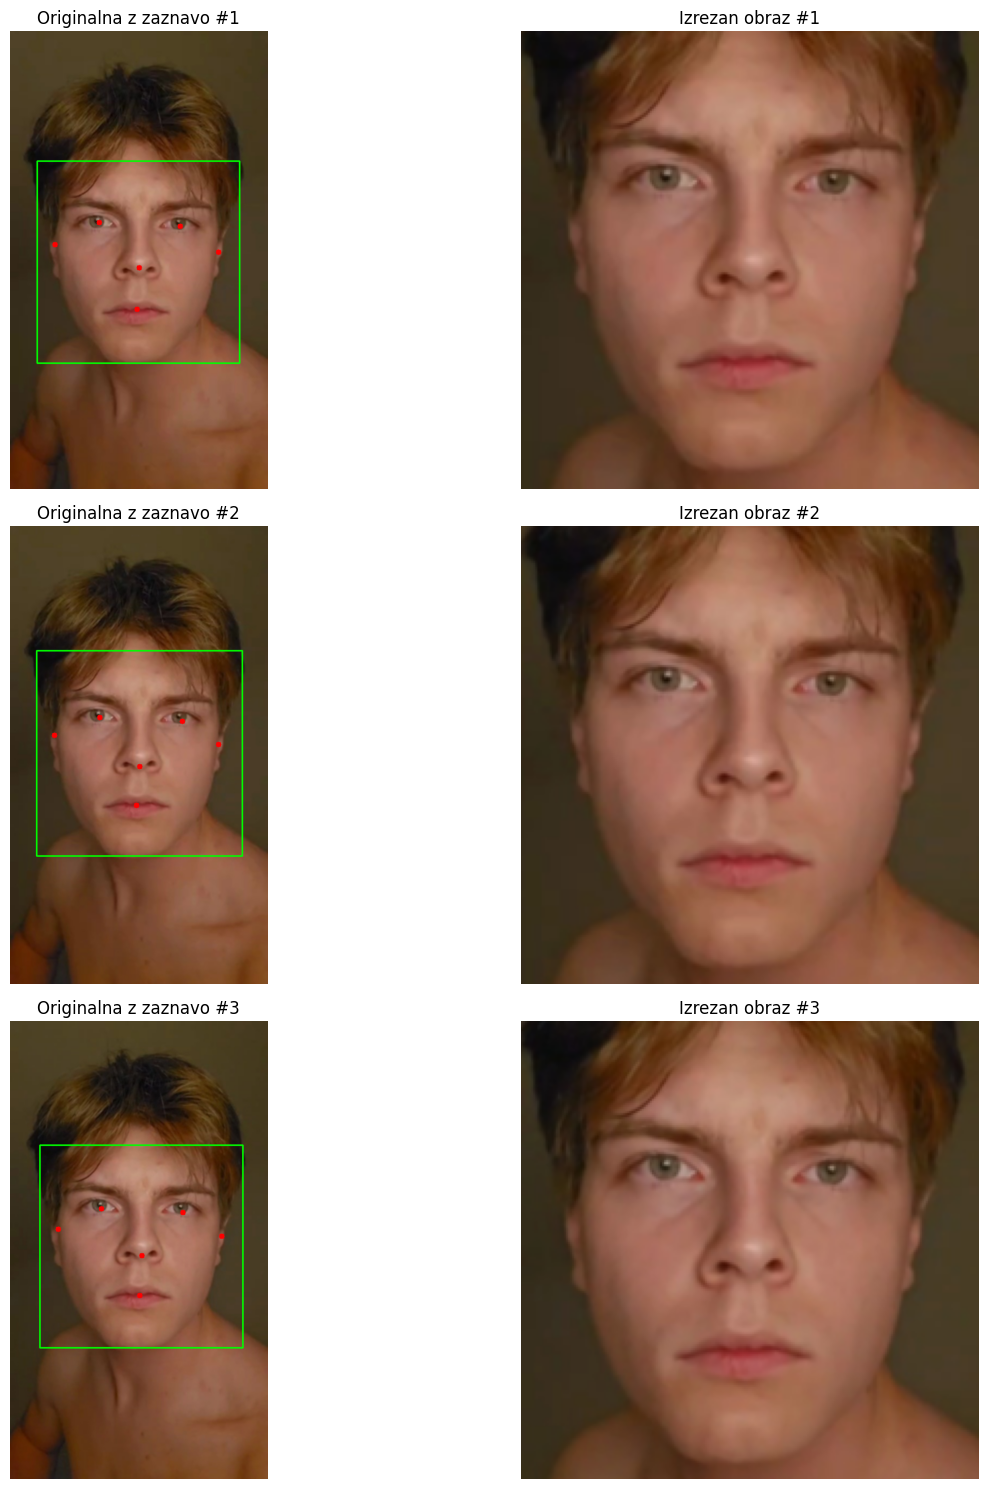


--- Slike, kjer obraz ni bil zaznan ---
Vse slike so bile uspešno zaznane in obdelane (ali pa ni bilo slik za obdelavo).


In [53]:
if examples_for_display:
    plt.figure(figsize=(15, 5 * len(examples_for_display))) # Figura za prikaz več primerov

    for idx, example in enumerate(examples_for_display):
        # Prikaz originalne slike z bounding boxom
        plt.subplot(len(examples_for_display), 2, idx * 2 + 1)
        plt.imshow(example['original_with_bbox'])
        plt.title(f'Originalna z zaznavo #{idx+1}')
        plt.axis('off')

        # Prikaz končnega obdelanega obraza
        plt.subplot(len(examples_for_display), 2, idx * 2 + 2)
        plt.imshow(example['processed_face'])
        plt.title(f'Izrezan obraz #{idx+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("Ni primerov za prikaz obdelanih obrazov. Preveri, ali so bili obrazi zaznani in obdelani.")

# --- Prikaz slik, kjer obraz ni bil zaznan ---
print("\n--- Slike, kjer obraz ni bil zaznan ---")
if unprocessed_images_for_display:
    plt.figure(figsize=(15, 5 * ((len(unprocessed_images_for_display) + 2) // 3))) # Dinamična višina figure
    for idx, item in enumerate(unprocessed_images_for_display):
        plt.subplot(1, len(unprocessed_images_for_display), idx + 1)
        plt.imshow(item['image'])
        plt.title(f"Nezazanano: {item['name']}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Vse slike so bile uspešno zaznane in obdelane (ali pa ni bilo slik za obdelavo).")

## 4 Razdelitev podatkov na testno in ucno mnozico

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm # Za lep progress bar pri zbiranju datotek

### --- Konfiguracija poti ---

In [90]:
POSITIVE_DATA_FOLDER = '../data/persons/oseba_1/processed' # Tvoje obdelane slike obraza
NEGATIVE_DATA_FOLDER = '../data/processed/false_data'    # Obdelane LFW slike

OUTPUT_CSV_DIR = '../data/splits' # Mapa za shranjevanje CSV datotek
OUTPUT_FINAL_IMAGES_DIR = '../data/persons/oseba_1/final_dataset_images_processed' # Mapa za kopiranje slik v končno strukturo

### --- Razmerja delitve ---

In [ ]:
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# --- Razmerje negativnih vs. pozitivnih slik ---
# Negativne slike bodo 2x številčnejše od pozitivnih
NEGATIVE_TO_POSITIVE_RATIO = 2

# --- Za reprodukcijo rezultatov ---
RANDOM_SEED = 42

### --- Ustvari izhodne mape, če ne obstajajo ---

In [ ]:
os.makedirs(OUTPUT_CSV_DIR, exist_ok=True)
os.makedirs(OUTPUT_FINAL_IMAGES_DIR, exist_ok=True)

# Podmape za shranjevanje dejanskih slik za Keras
os.makedirs(os.path.join(OUTPUT_FINAL_IMAGES_DIR, 'train', 'positive'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_FINAL_IMAGES_DIR, 'train', 'negative'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_FINAL_IMAGES_DIR, 'val', 'positive'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_FINAL_IMAGES_DIR, 'val', 'negative'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_FINAL_IMAGES_DIR, 'test', 'positive'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_FINAL_IMAGES_DIR, 'test', 'negative'), exist_ok=True)

### Zbiranje poti in label (oznak)

In [ ]:
print("1. Zbiranje poti do slik...")

# Zbiranje poti in label (oznak) za pozitivne slike
positive_image_paths = []
for filename in os.listdir(POSITIVE_DATA_FOLDER):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        positive_image_paths.append(os.path.join(POSITIVE_DATA_FOLDER, filename))
positive_labels = [1] * len(positive_image_paths) # 1 = pozitivni razred (tvoj obraz)

print(f"Najdenih pozitivnih slik: {len(positive_image_paths)}")

# Zbiranje poti in label (oznak) za negativne slike
negative_image_paths_all = []
for filename in os.listdir(NEGATIVE_DATA_FOLDER):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        negative_image_paths_all.append(os.path.join(NEGATIVE_DATA_FOLDER, filename))
        
print(f"Najdenih vseh negativnih slik: {len(negative_image_paths_all)}")

### Izberemo določeno število negativnih slik

In [ ]:
# Če nimamo dovolj negativnih slik, uporabimo vse, kar imamo
num_positive = len(positive_image_paths)
num_negative_to_select = min(len(negative_image_paths_all), num_positive * NEGATIVE_TO_POSITIVE_RATIO)

# Naključno izberemo negativne slike (če je na voljo več, kot jih potrebujemo)
np.random.seed(RANDOM_SEED) # Za ponovljivost izbire
negative_image_paths_selected = np.random.choice(
    negative_image_paths_all, 
    size=int(num_negative_to_select), 
    replace=False # Ne izbiramo iste slike večkrat
).tolist()
negative_labels = [0] * len(negative_image_paths_selected) # 0 = negativni razred (LFW)

print(f"Izbranih negativnih slik (2x poz. ali vse, če jih je manj): {len(negative_image_paths_selected)}")
print("-" * 30)

# --- Kombiniranje in delitev podatkov ---
all_image_paths = positive_image_paths + negative_image_paths_selected
all_labels = positive_labels + negative_labels

# Pretvori v numpy array za sklearn
X = np.array(all_image_paths)
y = np.array(all_labels)

### Delitev podatkov na učne, validacijske in testne množice (70/15/15%)

In [ ]:
print("2. Delitev podatkov na učne, validacijske in testne množice (70/15/15%)...")

# Prva delitev: Train vs. Temp (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=(VAL_RATIO + TEST_RATIO), 
    random_state=RANDOM_SEED, 
    stratify=y # Pomembno: Ohranja razmerje razredov v vsaki delitvi
)

# Druga delitev: Validation vs. Test iz Temp množice
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=(TEST_RATIO / (VAL_RATIO + TEST_RATIO)), # Računamo delež testa iz temp množice
    random_state=RANDOM_SEED, 
    stratify=y_temp # Pomembno: Ohranja razmerje razredov
)

print(f"Velikost učne množice: {len(X_train)} (Pozitivne: {np.sum(y_train)}, Negativne: {len(y_train) - np.sum(y_train)})")
print(f"Velikost validacijske množice: {len(X_val)} (Pozitivne: {np.sum(y_val)}, Negativne: {len(y_val) - np.sum(y_val)})")
print(f"Velikost testne množice: {len(X_test)} (Pozitivne: {np.sum(y_test)}, Negativne: {len(y_test) - np.sum(y_test)})")
print("-" * 30)

### --- Shranjevanje v CSV datoteke ---

In [ ]:
print(f"3. Shranjevanje poti in label v CSV datoteke v '{OUTPUT_CSV_DIR}'...")

# Ustvari DataFrame-e
df_train = pd.DataFrame({'image_path': X_train, 'label': y_train})
df_val = pd.DataFrame({'image_path': X_val, 'label': y_val})
df_test = pd.DataFrame({'image_path': X_test, 'label': y_test})

# Shrani v CSV
df_train.to_csv(os.path.join(OUTPUT_CSV_DIR, 'train_paths_labels.csv'), index=False)
df_val.to_csv(os.path.join(OUTPUT_CSV_DIR, 'val_paths_labels.csv'), index=False)
df_test.to_csv(os.path.join(OUTPUT_CSV_DIR, 'test_paths_labels.csv'), index=False)

print("CSV datoteke uspešno shranjene.")
print("-" * 30)

### --- Kopiranje slik v končno strukturo za Keras image_dataset_from_directory ---

In [65]:
# Ta korak je pomemben, da augmentacije in TensorFlow dataser funkcije delujejo gladko
# Lahko bi brali direktno iz CSV, a ta struktura je bolj standardna za Keras
print(f"4. Kopiranje slik v končno strukturo '{OUTPUT_FINAL_IMAGES_DIR}' za lažjo uporabo s Kerasom...")

import shutil

def copy_images_to_split_folders(df, split_name, output_base_dir):
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Kopiranje {split_name} slik"):
        original_path = row['image_path']
        label = row['label']
        
        # Določi ciljno mapo glede na labelo
        if label == 1:
            target_folder = os.path.join(output_base_dir, split_name, 'positive')
        else:
            target_folder = os.path.join(output_base_dir, split_name, 'negative')
            
        # Ustvari ime datoteke (lahko originalno ali novo unikatno, če so možna podvajanja imen)
        # Zaenkrat uporabimo kar originalno ime
        filename = os.path.basename(original_path)
        destination_path = os.path.join(target_folder, filename)
        
        # Prepreči kopiranje iste datoteke večkrat, če se skripta ponovno zažene
        if not os.path.exists(destination_path):
            shutil.copy(original_path, destination_path)

copy_images_to_split_folders(df_train, 'train', OUTPUT_FINAL_IMAGES_DIR)
copy_images_to_split_folders(df_val, 'val', OUTPUT_FINAL_IMAGES_DIR)
copy_images_to_split_folders(df_test, 'test', OUTPUT_FINAL_IMAGES_DIR)

print("\nSlike uspešno kopirane v končno strukturo.")
print(f"Sedaj lahko uporabite mape v '{OUTPUT_FINAL_IMAGES_DIR}' za treniranje modela.")

1. Zbiranje poti do slik...
Najdenih pozitivnih slik: 76
Najdenih vseh negativnih slik: 5651
Izbranih negativnih slik (2x poz. ali vse, če jih je manj): 152
------------------------------
2. Delitev podatkov na učne, validacijske in testne množice (70/15/15%)...
Velikost učne množice: 159 (Pozitivne: 53, Negativne: 106)
Velikost validacijske množice: 34 (Pozitivne: 11, Negativne: 23)
Velikost testne množice: 35 (Pozitivne: 12, Negativne: 23)
------------------------------
3. Shranjevanje poti in label v CSV datoteke v '../data/splits'...
CSV datoteke uspešno shranjene.
------------------------------
4. Kopiranje slik v končno strukturo '../data/persons/oseba_1/final_dataset_images_processed' za lažjo uporabo s Kerasom...


Kopiranje test slik: 100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 22894.67it/s]


Slike uspešno kopirane v končno strukturo.
Sedaj lahko uporabite mape v '../data/persons/oseba_1/final_dataset_images_processed' za treniranje modela.


## Augmetacija

### Definicija funkcij za augmentacijo

In [86]:
def augment_rotate(image, angle_range=(-30, 30)):
    """
    Ročna augmentacija: Rotacija slike.
    Poudarek: Ne uporabljam visokonivojskih knjižnic za rotacijo, ampak osnovne matrične transformacije.
    """
    angle = random.randint(angle_range[0], angle_range[1]) # Naključni kot rotacije
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # Izračunamo rotacijsko matriko
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    # Izvedemo rotacijo. Previdno: nekateri piksli se lahko izgubijo na robovih.
    rotated = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
    return rotated

def augment_flip(image):
    """
    Ročna augmentacija: Horizontalno zrcaljenje (flip).
    To je super, ker se obraz zrcali, kar je pogosto in ustvari novo varianto.
    """
    # 1 pomeni horizontalno zrcaljenje
    flipped = cv2.flip(image, 1)
    return flipped

def augment_brightness_contrast(image, alpha_range=(0.6, 1.4), beta_range=(-50, 50)):
    """
    Ročna augmentacija: Sprememba svetlosti in kontrasta.
    To mi pomaga simulirati različne svetlobne pogoje.
    alpha = faktor za kontrast (1.0 je original)
    beta = faktor za svetlost (0 je original)
    """
    alpha = random.uniform(alpha_range[0], alpha_range[1])
    beta = random.randint(beta_range[0], beta_range[1])

    # Uporabim np.clip, da ohranim vrednosti pikslov med 0 in 255
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted

def augment_add_noise(image, noise_factor=0.002):
    """
    Ročna augmentacija: Dodajanje Gaussovega šuma.
    To je kontroliran šum, da model postane robusten na določene motnje v realnosti.
    Ne gre za odstranjevanje šuma, ampak za dodajanje.
    """
    mean = 0
    # Standardni odklon šuma, ki ga bom dodal. Pomembno: ne pretiravam!
    sigma = noise_factor * 255
    
    # Ustvarim matriko šuma z enakimi dimenzijami kot slika
    gauss = np.random.normal(mean, sigma, image.shape).astype('uint8')
    
    # Dodam šum na sliko. Uporabim cv2.add za pravilno seštevanje pikslov.
    noisy_image = cv2.add(image, gauss)
    return noisy_image

# Seznam vseh augmentacijskih funkcij in njihovih opisov
augmentations = [
    (augment_rotate, "Rotacija"),
    (augment_flip, "Horizontalno Zrcaljenje"),
    (augment_brightness_contrast, "Sprememba Svetlosti/Kontrasta"),
    (augment_add_noise, "Dodajanje Gaussovega Šuma")
]

### Priprava poti izhodnih map 

In [91]:
# --- Konfiguracija poti ---
# Pot do originalnih učnih slik (kjer so razdeljene na positive/negative)
TRAIN_DATA_ORIGINAL_DIR = '../data/persons/oseba_1/final_dataset_images_processed/train'

# Pot do mape, kamor bomo shranili VSE augmentirane in originalne učne slike
# Za Keras image_dataset_from_directory
OUTPUT_AUGMENTED_TRAIN_DIR = '../data/persons/oseba_1/final_dataset_for_training/train'

# Pot do CSV datoteke z učnimi potmi in labeli (za referenco, ne nujno za branje slik)
TRAIN_CSV_PATH = '../data/final_dataset_splits_csv/train_paths_labels.csv'

### --- Priprava izhodnih map ---

In [92]:

print(f"Priprava izhodnih map v '{OUTPUT_AUGMENTED_TRAIN_DIR}'...")
if os.path.exists(OUTPUT_AUGMENTED_TRAIN_DIR):
    shutil.rmtree(OUTPUT_AUGMENTED_TRAIN_DIR) # Praznimo, da se izognemo podvajanjem
os.makedirs(os.path.join(OUTPUT_AUGMENTED_TRAIN_DIR, 'positive'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_AUGMENTED_TRAIN_DIR, 'negative'), exist_ok=True)
print("Izhodne mape pripravljene.")

Priprava izhodnih map v '../data/persons/oseba_1/final_dataset_for_training/train'...
Izhodne mape pripravljene.


### Razvrscanje v izhodne podmape

In [88]:
total_augmented_images_count = 0
display_examples = []
example_limit_per_class = 2 # Prikazal bom original in nekaj augmentiranih verzij za vsak razred

# Iteriramo skozi obe podmapi: 'positive' in 'negative'
for class_name in ['positive', 'negative']:
    current_class_folder = os.path.join(TRAIN_DATA_ORIGINAL_DIR, class_name)
    output_class_folder = os.path.join(OUTPUT_AUGMENTED_TRAIN_DIR, class_name)

    all_original_images_in_class = [f for f in os.listdir(current_class_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    print(f"\nZačenjam z augmentacijo za razred '{class_name}' ({len(all_original_images_in_class)} originalnih slik)...")

    # Uporabimo tqdm za progress bar pri obdelavi slik v vsakem razredu
    with tqdm(total=len(all_original_images_in_class), desc=f"Augmentacija {class_name} slik") as pbar:
        for i, original_image_name in enumerate(all_original_images_in_class):
            original_image_path = os.path.join(current_class_folder, original_image_name)
            
            image_bgr = cv2.imread(original_image_path)

            if image_bgr is None:
                # print(f"Opozorilo: Slike ni mogoče naložiti: {original_image_path}. Preskakujem.")
                pbar.update(1) # Posodobimo progress bar, čeprav smo preskočili
                continue

            image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

            # --- 1. Shranim originalno sliko v končno augmentirano mapo ---
            # To je pomembno, da originali ostanejo del učne množice
            original_output_path = os.path.join(output_class_folder, f"original_{original_image_name}")
            cv2.imwrite(original_output_path, cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))
            total_augmented_images_count += 1
            
            # Prikaži primere samo za prvi dve sliki vsakega razreda
            if i < example_limit_per_class and class_name == 'positive': # Primeri samo za pozitivni razred
                if len(display_examples) < example_limit_per_class * (len(augmentations) + 1): # +1 za original
                    display_examples.append((f'Originalna ({class_name})', image_rgb))


            # --- 2. Izvedem in shranim vsako augmentacijo ---
            for j, (augment_func, aug_name) in enumerate(augmentations):
                augmented_image = augment_func(image_rgb)
                
                # Shranim augmentirano sliko z unikatnim imenom
                augmented_filename = f"aug_{j}_{original_image_name}"
                augmented_output_path = os.path.join(output_class_folder, augmented_filename)
                cv2.imwrite(augmented_output_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))
                total_augmented_images_count += 1

                if i < example_limit_per_class and class_name == 'positive':
                    if len(display_examples) < example_limit_per_class * (len(augmentations) + 1):
                        display_examples.append((f'{aug_name} ({class_name})', augmented_image))
            
            pbar.update(1) # Posodobimo progress bar po obdelavi vsake originalne slike

print(f"\nKončano kopiranje. Ustvarjenih skupaj {total_augmented_images_count} slik. Shranjene v: {OUTPUT_AUGMENTED_TRAIN_DIR}")
print("-" * 30)

Priprava izhodnih map v '../data/persons/oseba_1/final_dataset_for_training/train'...
Izhodne mape pripravljene.

Začenjam z augmentacijo za razred 'positive' (53 originalnih slik)...


Augmentacija positive slik: 100%|█████████████████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 324.98it/s]



Začenjam z augmentacijo za razred 'negative' (106 originalnih slik)...


Augmentacija negative slik: 100%|███████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 318.66it/s]



Končana augmentacija. Ustvarjenih skupaj 795 slik. Shranjene v: ../data/persons/oseba_1/final_dataset_for_training/train
------------------------------
Kopiranje validacijskih in testnih slik v končno strukturo...
Kopiranje validacijski podatkov...


Kopiranje validacijski negative slik: 100%|█████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 44414.82it/s]


validacijski podatki uspešno kopirani.
Kopiranje testni podatkov...


Kopiranje testni negative slik: 100%|███████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 56779.87it/s]

testni podatki uspešno kopirani.

Celotna priprava podatkov je zaključena!
Končna struktura podatkov je v: '../data/persons/oseba_1/final_dataset_for_training/train' (za učno) in '../data/persons/oseba_1/final_dataset_for_training/val' / '../data/persons/oseba_1/final_dataset_for_training/test'


### Kopiranje validacijskih in testnih slik v končno strukturo

In [ ]:
print("Kopiranje validacijskih in testnih slik v končno strukturo...")

# Pot do originalnih validacijskih in testnih slik
VAL_DATA_ORIGINAL_DIR = '../data/persons/oseba_1/final_dataset_images_processed/val'
TEST_DATA_ORIGINAL_DIR = '../data/persons/oseba_1/final_dataset_images_processed/test'

# Pot do končne strukture za validacijske in testne slike (brez augmentacije)
OUTPUT_FINAL_VAL_DIR = '../data/persons/oseba_1/final_dataset_for_training/val'
OUTPUT_FINAL_TEST_DIR = '../data/persons/oseba_1/final_dataset_for_training/test'

# Priprava izhodnih map za val/test
os.makedirs(os.path.join(OUTPUT_FINAL_VAL_DIR, 'positive'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_FINAL_VAL_DIR, 'negative'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_FINAL_TEST_DIR, 'positive'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_FINAL_TEST_DIR, 'negative'), exist_ok=True)


def copy_non_augmented_split(source_base_dir, dest_base_dir, split_name):
    print(f"Kopiranje {split_name} podatkov...")
    for class_name in ['positive', 'negative']:
        source_folder = os.path.join(source_base_dir, class_name)
        dest_folder = os.path.join(dest_base_dir, class_name)
        
        images = [f for f in os.listdir(source_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        with tqdm(total=len(images), desc=f"Kopiranje {split_name} {class_name} slik") as pbar:
            for img_name in images:
                src_path = os.path.join(source_folder, img_name)
                dest_path = os.path.join(dest_folder, img_name)
                if not os.path.exists(dest_path):
                    shutil.copy(src_path, dest_path)
                pbar.update(1)
    print(f"{split_name} podatki uspešno kopirani.")

copy_non_augmented_split(VAL_DATA_ORIGINAL_DIR, OUTPUT_FINAL_VAL_DIR, 'validacijski')
copy_non_augmented_split(TEST_DATA_ORIGINAL_DIR, OUTPUT_FINAL_TEST_DIR, 'testni')

print("\nCelotna priprava podatkov je zaključena!")
print(f"Končna struktura podatkov je v: '{OUTPUT_AUGMENTED_TRAIN_DIR}' (za učno) in '{OUTPUT_FINAL_VAL_DIR}' / '{OUTPUT_FINAL_TEST_DIR}'")

### --- Prikaz primerov augmentiranih slik ---


Prikaz primerov augmentiranih slik (original in nekaj različic):


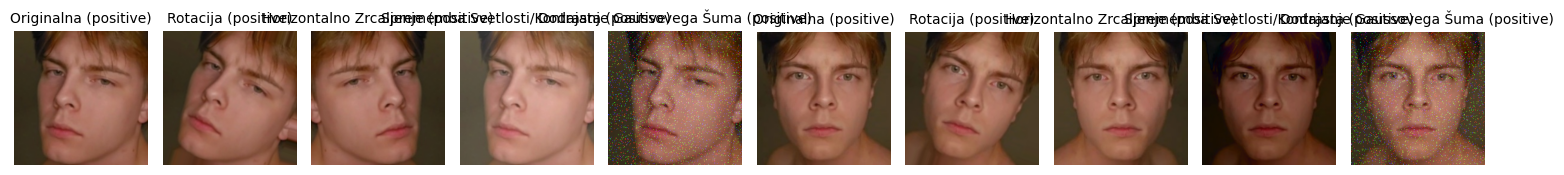

In [115]:
print("\nPrikaz primerov augmentiranih slik (original in nekaj različic):")

if display_examples:
    plt.figure(figsize=(15, 6)) # Prilagodi velikost figure
    num_examples_to_show = len(display_examples) # Prikaži vse zbrane primere

    for i, (title, img) in enumerate(display_examples):
        plt.subplot(1, num_examples_to_show, i + 1) # Ustvari podgraf (vrstice, stolpci, index)
        plt.imshow(img) # Prikaz RGB slike
        plt.title(title, fontsize=10) # Naslov za vsako sliko
        plt.axis('off') # Odstrani osi
    plt.tight_layout() # Prilagodi postavitev, da se naslovi ne prekrivajo
    plt.show()
else:
    print("Ni zbranih primerov za prikaz. Preveri poti in podatke.")